# Обучение и тестирование модели SaSRec с лоссами CE и CCE на датасете MovieLens-20m

### 1. Импорты

In [2]:
#!pip install "cut-cross-entropy @ git+https://github.com/apple/ml-cross-entropy.git"

In [3]:
import os

project_path = '/content/drive/MyDrive/CutCrossEntropy'
os.chdir(project_path)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.preprocessing import LabelEncoder

import torch
from torch.utils.data import Dataset
import time
from cut_cross_entropy import linear_cross_entropy

In [5]:
from src.model import SASRec
from src.train import train_epoch, run_training
from src.dataset import prepare_data, build_dataset, SASRecDataset
from src.evaluate import evaluate
from src.metrics import Metrics
from src.utils import plot_loss

In [6]:
import logging

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

# Заново сконфигурировать
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s [%(levelname)s] %(message)s'
)

logger = logging.getLogger(__name__)

In [7]:
!nvidia-smi

Wed Jul 30 16:54:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 2. Обработка и подготовка данных

Датасет MovieLens-20m

In [8]:
path_dataset = 'data/ratings.csv'
df = pd.read_csv(path_dataset)

df = df[['userId','movieId','timestamp']]
df.columns = ['user_id', 'item_id', 'datetime']

df.shape

(20000263, 3)

In [20]:
max_len = 50 #512
batch_size = 256
logger.info(f'Maximum sequence length = {max_len}, batch size = {batch_size}')
# Загрузка
user_seqs, num_users, num_items, _, _ = prepare_data(df, min_user_inter=3, min_item_inter=3)

# Сплиты
train_data, val_data, test_data = build_dataset(user_seqs, max_len=max_len)

# Dataset и DataLoader
train_dataset = SASRecDataset(train_data, max_len=max_len, num_items=num_items)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = SASRecDataset(val_data, max_len=max_len, num_items=num_items)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SASRecDataset(test_data, max_len=max_len, num_items=num_items)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Пример
for batch in train_loader:
    _, seqs, targets = batch
    print("Seqs:", seqs.shape)       # [B, T]
    print("Targets:", targets.shape) # [B]
    break

2025-07-30 17:52:41,007 [INFO] Maximum sequence length = 50, batch size = 256
2025-07-30 17:52:41,008 [INFO] Filter users with interactions < 3 and items with interactions < 3
2025-07-30 17:52:45,203 [INFO] Encoding
2025-07-30 17:52:52,359 [INFO] N users: 138493, N items: 20729
2025-07-30 17:52:52,362 [INFO] Groupping


Seqs: torch.Size([256, 49])
Targets: torch.Size([256])


### 3. Обучение

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Обучение на",device)

Обучение на cuda


#### 3.1 CE Loss

In [45]:
model_ce, res_ce, mem_ce = run_training(
    model_class=SASRec,
    num_items=num_items,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_type='CE',
    device=device,
    n_epochs=5,
    hidden_dim=64,
    max_len=max_len,
    lr=0.001
)


2025-07-30 18:08:24,756 [INFO] Loss = CE


cuda


Epoch 1: 100%|██████████| 541/541 [00:11<00:00, 46.13it/s, loss=13.9302]


{'train_loss': 13.5617, 'train_time_s': 11.73, 'val_loss': 8.7595, 'val_time_s': 5.91, 'epoch': 1}


Epoch 2: 100%|██████████| 541/541 [00:11<00:00, 47.34it/s, loss=8.4735]


{'train_loss': 8.4561, 'train_time_s': 11.43, 'val_loss': 8.2249, 'val_time_s': 6.87, 'epoch': 2}


Epoch 3: 100%|██████████| 541/541 [00:11<00:00, 47.79it/s, loss=8.1090]


{'train_loss': 8.1055, 'train_time_s': 11.32, 'val_loss': 8.0781, 'val_time_s': 6.6, 'epoch': 3}


Epoch 4: 100%|██████████| 541/541 [00:11<00:00, 47.26it/s, loss=7.9775]


{'train_loss': 7.9748, 'train_time_s': 11.45, 'val_loss': 8.0003, 'val_time_s': 6.02, 'epoch': 4}


Epoch 5: 100%|██████████| 541/541 [00:12<00:00, 42.98it/s, loss=7.8881]


{'train_loss': 7.8857, 'train_time_s': 12.59, 'val_loss': 7.9185, 'val_time_s': 6.94, 'epoch': 5}


In [46]:
res_ce

,train_loss,train_time_s,val_loss,val_time_s,epoch
0,13.5617,11.73,8.7595,5.91,1
1,8.4561,11.43,8.2249,6.87,2
2,8.1055,11.32,8.0781,6.60,3
3,7.9748,11.45,8.0003,6.02,4
4,7.8857,12.59,7.9185,6.94,5


In [47]:
print(f'Среднее время обучения на одну эпоху = {int(res_ce.train_time_s.mean())} с')
print(f'Максимальная память = {mem_ce} ГБ')

Среднее время обучения на одну эпоху = 11 с
Максимальная память = 0.2630348205566406 ГБ


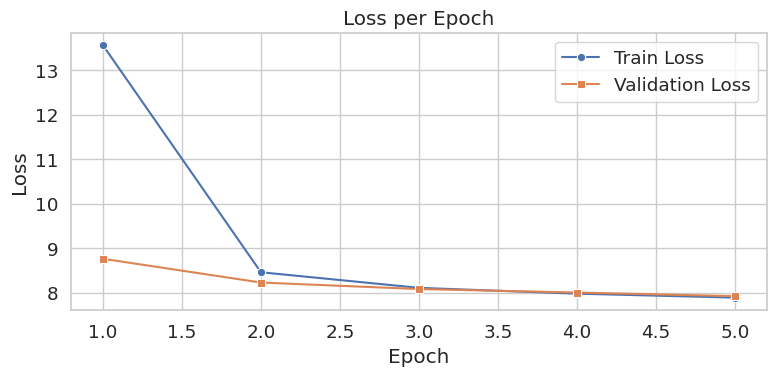

In [48]:
plot_loss(res_ce)

#### 3.2 CCE Loss

In [39]:
model_cce, res_cce, mem_cce = run_training(
    model_class=SASRec,
    num_items=num_items,
    train_loader=train_loader,
    val_loader=val_loader,
    loss_type='CCE',
    device=device,
    n_epochs=10,
    hidden_dim=64,
    max_len=max_len,
    lr=0.0005
)

2025-07-30 18:03:41,165 [INFO] Loss = CCE


cuda


Epoch 1: 100%|██████████| 541/541 [00:12<00:00, 44.31it/s, loss=17.2556]


{'train_loss': 16.802, 'train_time_s': 12.21, 'val_loss': 10.656, 'val_time_s': 6.06, 'epoch': 1}


Epoch 2: 100%|██████████| 541/541 [00:12<00:00, 44.64it/s, loss=9.7462]


{'train_loss': 9.6862, 'train_time_s': 12.12, 'val_loss': 8.7918, 'val_time_s': 7.17, 'epoch': 2}


Epoch 3: 100%|██████████| 541/541 [00:13<00:00, 40.75it/s, loss=8.6028]


{'train_loss': 8.5872, 'train_time_s': 13.28, 'val_loss': 8.3837, 'val_time_s': 6.08, 'epoch': 3}


Epoch 4: 100%|██████████| 541/541 [00:12<00:00, 44.10it/s, loss=8.2851]


{'train_loss': 8.2799, 'train_time_s': 12.27, 'val_loss': 8.223, 'val_time_s': 7.12, 'epoch': 4}


Epoch 5: 100%|██████████| 541/541 [00:11<00:00, 45.56it/s, loss=8.1437]


{'train_loss': 8.1405, 'train_time_s': 11.88, 'val_loss': 8.1492, 'val_time_s': 6.15, 'epoch': 5}


Epoch 6: 100%|██████████| 541/541 [00:11<00:00, 45.73it/s, loss=8.0694]


{'train_loss': 8.0705, 'train_time_s': 11.83, 'val_loss': 8.1093, 'val_time_s': 6.07, 'epoch': 6}


Epoch 7: 100%|██████████| 541/541 [00:11<00:00, 45.47it/s, loss=8.0288]


{'train_loss': 8.0286, 'train_time_s': 11.9, 'val_loss': 8.083, 'val_time_s': 7.42, 'epoch': 7}


Epoch 8: 100%|██████████| 541/541 [00:12<00:00, 44.42it/s, loss=7.9985]


{'train_loss': 8.0017, 'train_time_s': 12.18, 'val_loss': 8.0717, 'val_time_s': 6.14, 'epoch': 8}


Epoch 9: 100%|██████████| 541/541 [00:13<00:00, 41.38it/s, loss=7.9849]


{'train_loss': 7.9848, 'train_time_s': 13.08, 'val_loss': 8.063, 'val_time_s': 7.08, 'epoch': 9}


Epoch 10: 100%|██████████| 541/541 [00:12<00:00, 44.59it/s, loss=7.9748]


{'train_loss': 7.9755, 'train_time_s': 12.13, 'val_loss': 8.0586, 'val_time_s': 6.2, 'epoch': 10}


In [40]:
res_cce

,train_loss,train_time_s,val_loss,val_time_s,epoch
0,16.8020,12.21,10.6560,6.06,1
1,9.6862,12.12,8.7918,7.17,2
2,8.5872,13.28,8.3837,6.08,3
3,8.2799,12.27,8.2230,7.12,4
4,8.1405,11.88,8.1492,6.15,5
5,8.0705,11.83,8.1093,6.07,6
6,8.0286,11.90,8.0830,7.42,7
7,8.0017,12.18,8.0717,6.14,8
8,7.9848,13.08,8.0630,7.08,9
9,7.9755,12.13,8.0586,6.20,10


In [41]:
print(f'Среднее время обучения на одну эпоху = {int(res_cce.train_time_s.mean())} с')
print(f'Максимальная память = {mem_cce} ГБ')

Среднее время обучения на одну эпоху = 12 с
Максимальная память = 0.20491600036621094 ГБ


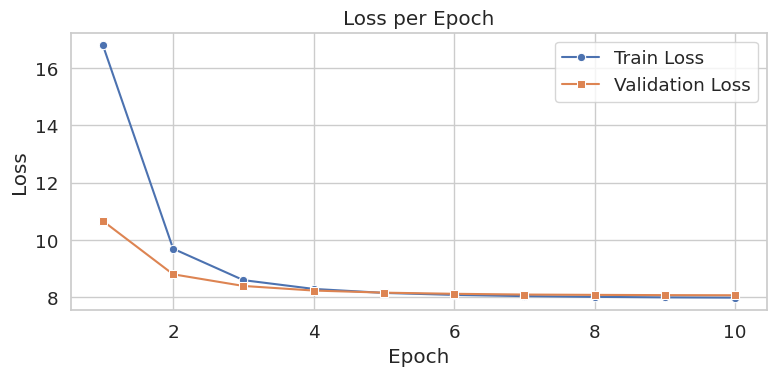

In [42]:
plot_loss(res_cce)

### 4. Тестирование

#### 4.1 CE Loss

In [49]:
scores_ce = evaluate(model_ce, test_loader, device)

100%|██████████| 541/541 [00:16<00:00, 31.98it/s]


In [50]:
metrics = Metrics(k=10, train=train_data)
metrics.compute(scores_ce)

{'HitRate@10': 0.033814,
 'NDCG@10': 0.015521,
 'Coverage@10': 0.005934,
 'Surprisal@10': 0.094077}

#### 4.2 CCE Loss

In [43]:
scores = evaluate(model_cce, test_loader, device)

100%|██████████| 541/541 [00:16<00:00, 32.14it/s]


In [44]:
metrics = Metrics(k=10, train=train_data)
metrics.compute(scores)

{'HitRate@10': 0.030998,
 'NDCG@10': 0.014186,
 'Coverage@10': 0.001303,
 'Surprisal@10': 0.080424}